# 8. 뉴스 요약봇 만들기 🖥

## 8-1. 텍스트 요약 (Text Summarization)
: 길이가 긴 문서(document)를 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것
- 요약 전후 **정보 손실이 최소화**되야 함

### 🧤 추출적 요약 (Extractive Summarization)
: 단어 그대로 원문에서 문장들을 추출해 요약하는 방식 - `텍스트 랭크 (Text Rank)`
- but, 추출된 이 일부 문장들의 연결이 부자연스러울 수도 있다.
ex) 네이버 뉴스의 `요약봇` <br/>

### 🧤 추상적 요약 (Abstractive Summarization)
: 원문으로부터 내용이 요약된 새로운 문장 생성해내기 - `자연어 생성 (Natural Language Generation, NLG)`
- 원문의 구성 문장 중 어떤 문장이 요약문에 들어갈 핵심문장인지 판별한다는 점에서 `문장 분류(Text Classification) 문제`

## 8-2. 인공 신경망으로 텍스트 요약 훈련시키기
### 🧤 seq2seq(sequence-to-sequence)
: 2개의 RNN 아키텍처를 이용해 입력 시퀀스로부터 출력 시퀀스를 생성해내는 자연어 생성 모델
- 이를 이용해 *Abstractive Summarization(추상적 요약)*을 만들어보자. <br/>
- 이에 대한 자세한 설명은 https://wikidocs.net/24996 을 참조하여 https://yeon22.tistory.com/166 블로그에 담았다.

### ✔️ seq2seq 개요
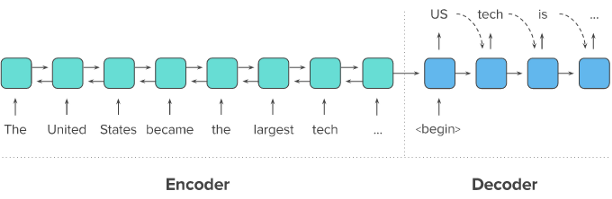
(출처: https://medium.com/dl-for-product-and-service/abstractive-text-summary-with-reinforcement-learning-ab2458ab29d5)

- 원문을 첫 번째 RNN 인코더로 입력하면, 인코더는 이를 하나의 고정된 벡터로 변환한다.
- 이 벡터를 문맥 정보를 가지고 있는 벡터라 하여 `컨텍스트 벡터(context vector)`라고 한다.
- 두 번째 RNN인 디코더는 이 context vector을 전달받아 한 단어씩 생성해내 요약 문장을 만들어낸다. <br>

### ✔️ LSTM과 컨텍스트 벡터
우린 seq2seq를 구현할 때 인코더/디코더로 바닐라 RNN이 아니라 LSTM을 이용할 것이다. <br/>
- LSTM과 바닐라 RNN의 다른 점은 인코더가 디코더에 컨텍스트 벡터에 hidden state와 cell state 두 값 모두 전달해야한다는 것 <br/>
- 자세한 내용은 https://yeon22.tistory.com/167

### ✔️ 시작 토큰과 종료 토큰
시작 토큰 `<SOS>`(start of a sequence)가 입력되면 종료 토큰 `<EOS>`(end of a sequence)가 입력되기 전까지 멈추지 않으므로 예측 시퀀스 앞, 뒤에 시작/종료 토큰을 넣어주는 전처리가 이루어져야 한다. <br/>

### ✔️ 어테션 메커니즘을 통한 새로운 컨텍스트 벡터 사용하기
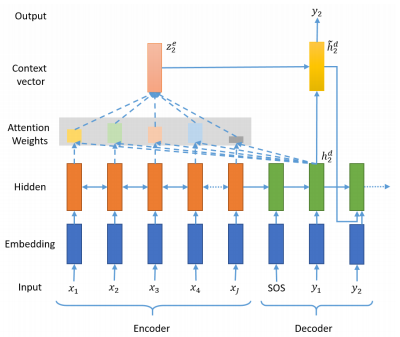
(기존의 컨텍스트 벡터보다 인코더의 정보를 적극적으로 활용해 성능을 끌어올리는 어텐션 메커니즘 https://arxiv.org/pdf/1812.02303.pdf) <br/>
- 기존 seq2seq는 인코더의 마지막 time step의 hidden state를 컨텍스트 벡터로 사용했는데, 우리가 사용할 `어텐션 메커니즘(Attention Mechanism)`은 인코더의 모든 step의 hidden state 정보가 컨텍스트 벡터에 전부 반영되도록 할 것이다.
- 이 때 각 hidden state에는 **가중치**를 주어 각 step이 현재의 예측에 얼마나 영향을 미치는지에 따라 다르게 부여할 것이다.
- 컨텍스트 벡터를 구성하기 위한 인코더 hidden state의 가중치 값은 **디코더의 현재 스텝이 어디냐에 따라 계속 달라진다.**
- 기존 seq2seq에서 컨텍스트 벡터는 디코더의 현재 스텝 위치와 무관하게 한 번 계산되면 고정값을 지녔다. <br/>

즉, 정리를 해보면 <br/>
1. seq2seq을 사용
2. RNN 계열 중 LSTM을 사용하므로 hidden state 뿐 아니라 cell state도 사용해야 함
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙임.
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작
5. seq2seq의 기본 모델과 달리, 어텐션 메커니즘을 이용한 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산함
6. 계산된 컨텍스트 벡터를 이용해 디코더는 다음 등장할 단어를 예측함

## 8-3. 데이터 준비하기
- 캐글에서 제공된 `아마존 리뷰 데이터셋` <br/>

#### 🧤 NLTK (Natural Language Toolkit)
: 영어 기호, 통계, 자연어처리를 위한 라이브러리
- 의미를 분석하고 요약하는데 거의 의미 없는 100여 개의 불용어(stopwords)가 미리 정의되어 있음
- 우리가 다운로드한 리뷰 파일에서 이 stopwords를 제거하는 작업을 진행해보자.

In [1]:
import nltk
nltk.download('stopwords') # NLTK 패키지에서 불용어 사전 다운로드

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Reviews.csv 파일은 총 568,454개의 샘플을 가지지만 여기선 간단히 10만 개의 샘플만 사용해보자

In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


우린 전체 데이터에서 Summary와 Text 열만 훈련에 사용할 것이다.

In [4]:
data = data[['Text', 'Summary']] # 별도로 저장
data.head()

# 랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
15535,I have been feeding my greyhounds these treats...,Excellent treats
46886,Have tried a couple flavers of PUR gum. This ...,No aspertame!!!
93997,"My dog, a little maltese, loves this product. ...",DOG LOVES IT
65349,"A long-time devotee, I don't expect to buy it ...","Goodbye, Chocolate Malt -- Hello, Malt Chocolate"
24392,"If your looking for a low calorie, fat free, O...",Tasty little treat!
61052,I don't think I had ever tried Mallomars befor...,"Really yummy, but arrived crumbled"
21372,These are a bit expensive but when it comes to...,Gives dog great breath
16640,I suppose the flavor of this carbonated juice ...,I would not buy it
72121,I really liked this. I am on a low sodium diet...,Great marinade
40805,I love everything about the Peace Ginger Raspb...,buy ginger raspberry instead


Text 시퀀스를 입력받으면 Summary 시퀀스를 예측하도록 인공 신경망을 훈련시키자.

## 8-4. 데이터 전처리하기 (1) 데이터 정리하기
### 중복 샘플과 null 값 존재하는 샘플 제거
- nunique()

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


- Text 자체가 중복된 경우는 제거해야 함
- Text가 달라도 Summary는 동일할 수 있음

In [6]:
# inplace=True: 데이터프레임 타임 값을 return 하지 않고, data 내부를 직접적으로 바꿈
data.drop_duplicates(subset=['Text'], inplace=True)
print('전체 샘플 수: ', len(data))

전체 샘플 수:  88426


-> 100,000개에서 88,426개로 줄어든 것을 확인할 수 있다.

In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수: ', len(data))

전체 샘플수:  88425


-> null 값을 하나 지워주어 총 샘플 수가 88,425개가 되었다. <br/>
중복 샘플과 null값 샘플을 지워 총 10만 개 중 1만 개 이상의 샘플이 제거되었다.

### 텍스트 정규화와 불용어 제거
예를 들어 `it'll`과 `it will`은 같은 표현인데, 이를 다른 단어로 간주해 연산량을 늘리기보단 기계 학습 전 미리 같은 표현으로 통일시켜주면 연산량을 줄일 수 있을 것이다.
### 🧤 텍스트 정규화 (Text Normalization)
#### 정규화 사전(dictionary)
- 출처: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 불용어(stopwords)
: 자연어 처리 시 실질적으로 별 도움이 되지 않는 단어들은 제거하는 것이 성능을 높일 것이다.
- 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해 샘플에서 불용어 제거하자.

In [10]:
# NLTK에서 제공하는 불용어 리스트
print('불용어 개수: ', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수:  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- 이렇게 불용어를 제거하는 작업 외에도 모든 영단어 소문자로 만들기, html 태그 제거하기, 특수문자 제거하기 등 정말 필요한 내용만 잘 학습할 수 있도록 처리할 것이다.
- 불용어 제거는 Text 전처리에서만 호출하고 Summary 전처리에서는 이용하지 않을 것.

#### ❓Why?
- Abstractive한 문장 요약 결과문이 자연스러운 문장이 되기 위해선 이 불용어들이 Summary에는 남아 있는 것이 더 좋을 것이라 판단. 이를 위해 `remove_stopwords`를 추가하고 if 문을 추가하자.

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text # <br />, <a href=...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens

전처리 전, 후의 결과를 확인해보자

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


Text의 경우 불용어를 제거하고, Summary의 경우 불용어를 제거하지 않을 것이므로 따로 호출해서 진행하자.

In [13]:
clean_text = []

# 전체 text 데이터에 대한 전처리: 10분 이상 소요
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
    
# 전처리 후 출력
print('Text 전처리 후 결과: ', clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [14]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리: 5분 이상 시간 소요
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False)) # 불용어 제거 수행하지 않는다는 의미의 False
    
print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


정제 후 빈(empty) 샘플이 생겼는지 확인해보자. 모든 단어가 사라졌을 가능성 있음!

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 null 값으로 변환
data.replace('', np.nan, inplace=True)

In [16]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

정제 과정에서 Summary 열에 70개의 null 값이 생김. 모두 제거해주자

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플 수: ', len(data))

전체 샘플 수:  88355


## 8-5. 데이터 전처리하기 (2) 훈련 데이터와 테스트 데이터 나누기
### 샘플의 최대 길이 정하기
Text와 Summary의 최소, 최대, 평균 길이를 구하고 길이 분포 시각화해보기

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


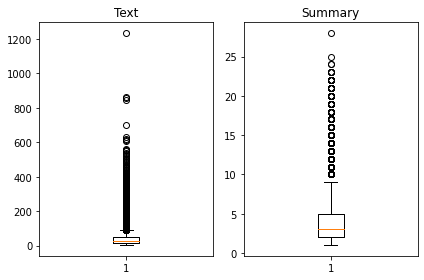

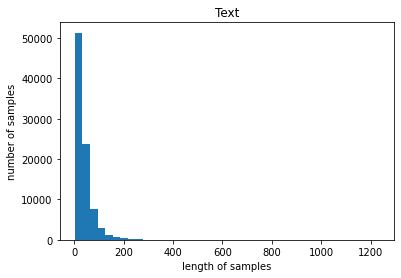

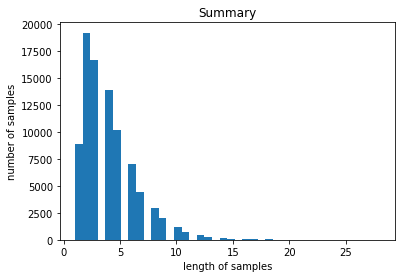

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1, 2, 2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text는 최대 길이가 1235, 평균은 38이지만 Summary는 최대 길이가 28, 평균 길이가 4이다. <br/>
이처럼 Text와 Summary의 길이 분포는 꽤나 차이가 나보인다. (Summary가 상대적으로 짧음)

In [19]:
# Text 최대 길이와 Summary의 최대 길이 적절히 임의로 정하기
text_max_len = 50
summary_max_len = 8

In [20]:
# 위의 길이가 적절한지 통계로 확인해보자.

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s.split()) <= max_len):
            cnt = cnt + 1
            
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


만약 padding을 하게 되면 설정한 길이보다 긴 샘플들은 잘리게 될 것이다. <br/>
우리는 임의로 정한 길이에 맞춰 자르지 않고, **정해진 길이보다 길면 제외하는 방법**을 이용하자

In [22]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플 수: ', len(data))

전체 샘플 수:  65818


### 시작 토큰과 종료 토큰 추가하기
디코더는 시작 토큰을 입력 받아 문장을 생성하고, 종료 토큰을 예측한 순간 문장 생성을 멈췄다. 
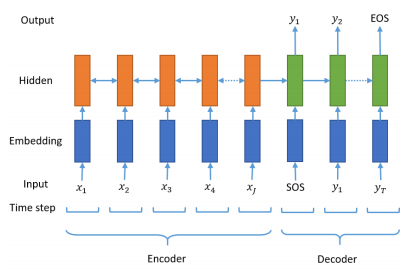https://arxiv.org/pdf/1812.02303.pdf
<br/><br/>
seq2seq에선 디코더의 입력과 레이블에 시작토큰, 종료토큰을 추가할 필요가 있다.
- 시작 토큰은 `sostoken`, 종료 토큰은 `eostoken`이라 명명하여 앞뒤로 추가하자.
- 디코더의 입력이며 시작 토큰이 맨 앞 쪽에 있는 문장은 `decoder_input`, 디코더의 출력(레이블)에 해당하며 종료 토큰이 맨 뒤에 붙은 문장은 `decoder_target`이라 명명하자.

In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가함
data['decoder_input'] = data['Summary'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['Summary'].apply(lambda x: x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [24]:
encoder_input = np.array(data['Text']) # 인코더의 입력 (Text)
decoder_input = np.array(data['decoder_input']) # 디코더의 입력 (sostoken + Summary)
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블 (Summary + endtoken)

`encoder_input`과 크기, 형태가 같은 순서가 섞인 정수 시퀀스 만들기

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[53844 11807 11371 ... 55846 32594 22463]


이 정수 시퀀스를 통해 데이터의 샘플 순서 정의해주면 잘 섞인 샘플이 될 것

In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoer_target = decoder_target[indices]

8:2의 비율로 훈련/테스트 데이터 분리

In [27]:
n_of_val = int(len(encoder_input) * 0.2)
print('테스트 데이터의 수: ', n_of_val)

테스트 데이터의 수:  13163


In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


## 8-6. 데이터 전처리하기 (3) 정수 인코딩
### 단어 집합(vocabulary) 만들기 및 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련/테스트 단어들을 모두 정수로 바꾸어줘야 한다.
- **단어 집합(vocabularay)** 만들기: 각 단어에 고유한 정수 매핑하는 작업
- keras의 토크나이저를 이용하면 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [29]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

- `fit_on_texts()` 메서드: 문자 데이터를 입력 받아 리스트의 형태로 변환
- 이렇게 단어 집합이 생김과 동시에 각 단어에 고유한 정수가 부여되었고, 이는 `src_tokenizer.word_index`에 저장되어 있다.
- 여기서 ***빈도수가 낮은 단어들***은 훈련데이터에서 제외하자.

등장 빈도수가 7회 미만인 단어의 비중을 확인해보자
- `src_tokenizer.word_counts.itmes()`: 단어와 각 단어의 등장 빈도수가 저장됨

In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수 카운트
total_freq = 0 # 훈련 빈도수의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 낮은 단어의 등장 빈도수 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in src_tokenizer.word_counts.items():
    total_freq += value # 총 빈도수
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt += 1
        rare_freq = rare_freq + value # rare 빈도수
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32009
등장 빈도가 6번 이하인 희귀 단어의 수: 23773
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8236
단어 집합에서 희귀 단어의 비율: 74.26973663657095
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3918102826153653


- `encoder_input_train`에는 3만 여개의 단어가 있다.
- 등장 빈도가 7 미만인 단어들은 74%나 되지만 전체 빈도수로 따지면 3.38%밖에 되지 않는다.
- 이 단어들은 정수 인코딩 과정에서 제외하고, 훈련 데이터에서 제거하자.
- 단어 집합의 크기를 num_words으로 8,000으로 제한해보자.

In [31]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

`texts_to_sequences()`: 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 **정수**로 변환하는 정수 인코딩
- 8000이 넘는 숫자들은 정수 인코딩 후 존재하지 않을 것

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[6, 1535, 323, 1676, 87, 1192, 19, 134, 2652, 1715, 2079, 26, 39, 2091, 153, 52, 6, 797, 513, 531, 5, 1847, 338, 521, 2226, 920, 1059, 257, 1009], [1, 4, 156, 3141, 449, 1228, 593, 453, 5286, 20, 392, 174, 82, 69, 30, 156, 18, 2264, 3352, 449, 1228, 3808, 336, 64, 34, 533, 140, 593, 453, 67, 671, 5647, 1228, 43, 301], [2138, 5458, 957, 651, 39, 22, 104, 32, 235, 550, 24, 2961, 104, 1574, 79, 61, 45, 173, 69, 113, 287, 113, 245, 13, 23, 13, 2962, 420, 58, 78, 202, 78, 202, 10, 1509, 1, 39, 104, 15, 79, 2, 1350, 1350, 2963]]


Summary 데이터에 대해서도 동일한 작업 수행

In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10539
등장 빈도가 5번 이하인 희귀 단어의 수: 8166
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2373
단어 집합에서 희귀 단어의 비율: 77.48363222317109
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.943882502641965


마찬가지로 단어 집합 크기를 2000으로 제한하자

In [35]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ', decoder_input_train[:5])
print('target')
print('decoder ', decoder_target_train[:5])

input
input  [[1, 26, 48, 307], [1, 32, 275], [1, 116, 59, 11, 25, 109, 140], [1, 58, 387, 58, 329, 58, 1433, 58, 1695], [1, 240, 75, 44, 5, 134]]
target
decoder  [[4, 68, 25, 35, 2], [6, 48, 416, 2], [453, 521, 12, 81, 2], [1527, 1073, 2], [3, 1057, 2]]


- 이로써 현재 decoder_input_train과 decoder_target_train에는 숫자 2000이 넘는 숫자는 존재하지 않는다.
- 우린 전체 데이터에서 빈도수가 낮은 단어를 삭제 했는데, 이럴 경우 빈도수가 낮은 단어로만 구성되었던 샘플들은 empty 샘플이 되었을 가능성이 있다. -> 애초에 평균 길이가 4밖에 되지 않았던 Summary의 경우 더 심한 문제일 것 <br/>
- Summary에서 길이가 0이 된 샘플들의 인덱스 받아보자.
- 주의해야 할 것은 `decoder_input`엔 `sostoken` 또는 `decoder_target`에는 `endstoken`이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 길이가 0인 요약문의 실제 길이가 1로 나올 것이다.
    - 훈련/테스트 데이터에서 요약문의 길이가 1인 경우의 인덱스를 각각 `drop_train`과 `drop_test` 변수에 저장하자.

In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1303
삭제할 테스트 데이터의 개수 : 292
훈련 데이터의 개수 : 51352
훈련 레이블의 개수 : 51352
테스트 데이터의 개수 : 12871
테스트 레이블의 개수 : 12871


### 패딩하기
이제 서로 다른 길이의 샘플들을 같은 길이로 맞춰주는 패딩 작업을 하자. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 맞춰주자.

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 8-7. 모델 설계하기
함수형 API를 이용해 인코더 설계해보자.

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- embedding vector의 차원은 128로, hidden state의 크기는 256으로 정의함
- `hidden_state`: LSTM에서 얼만큼의 수용력(capacity)를 가질지 정하는 파라미터
    - LSTM의 용량 크기, LSTM에서의 뉴런의 크기라 생각하자.
    - 무조건 capacity를 늘린다고 성능이 증가하는 것은 아니다.
- 인코더의 LSTM은 총 3개의 층으로 구성해 모델의 복잡도를 높였다.
    - hidden_state의 크기를 늘리는 것이 **LSTM의 층 1개 용량**을 늘린다면, 3개의 층을 사용하는 것은 **모델의 용량**을 늘린다고 할 수 있다.
    - 3개의 층을 지난 인코더로부터 나온 출력 벡터는 디코더로 보내줘야 한다. <br/> <br/>
    
- 일반적인 `dropout`: 레이어의 weight를 **랜덤**으로 생략하여 모델의 overfitting을 막아줌
- LSTM에서 사용하는 `recurrent_dropout`: dropout을 레이어가 아닌 **time step**마다 해줌
    - time step의 입력을 랜덤으로 생략해주는 것
    - 일반적인 dropout과 같이 **regularization**해주는 효과가 있고, **과적합을 방지**함 <br/>
    
(Dropout: 입력할 때 드롭할 비율 / Recurrent Dropout: 순환할 때 드롭할 비율)

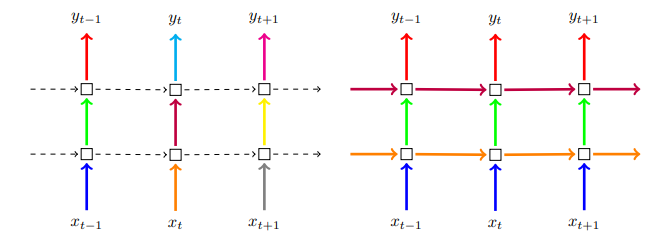
(출처: https://arxiv.org/pdf/1512.05287.pdf) <br/>
왼쪽이 dropout, 오른쪽이 dropout + recurrent dropout 동시에 사용
- dropout과 recurrent dropout을 모두 사용한 것을 variational dropout이라 함
- (+) recurrent dropout을 사용하면 경고문이 뜨는데, 이는 recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어 recurrent dropout을 사용하지 않을 때보다 학습시간이 오래 걸린다는 문구이다.

디코더 설계

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) # 체크

- 디코더의 설계는 인코더와 거의 동일하지만 LSTM의 입력을 정의할 때 `initial_state`의 인자값으로 hidden_state와 cell_state의 값을 넣어줘야 함.
    - 이것이 위에서 LSTM과 바닐라 RNN의 차이점이라 설명함!

디코더의 출력층 설계

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 **다중 클래스 분류 문제**를 풀어야 한다. 그렇기에 Dense의 인자로 `tar_vocab`을 주고, 활성화 함수로는 softmax를 사용한다.
- softmax는 다중 분류에 유용한 활성화 함수!

### 어텐션 매커니즘
- 우린 지금까지 인코더의 hidden state, cell state를 디코더의 초기 state로 사용하는 기본적인 seq2seq를 사용했다.
- 디코더의 출력층의 설계를 살짝 바꿔 성능을 높일 수 있는 방법이 **어텐션 매커니즘**이다.
- 어텐션 매커니즘을 수행한다는 뜻은 새로운 신경망을 설계해야 한다는 뜻이므로 다음 기회에 해보고, 여기선 Tensorflow에서 이미 구현된 어텐션 함수를 가져와 디코더의 출력층에 어떤 방식으로 결합되는지 배워보자.
- Bahdanau 스타일의 어텐션 함수 이용

아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해보자.
- 아래 코드는 인코더의 hidden state와 디코더의 hidden state를 어텐션 함수의 입력(attn_out)으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태(decoder_concat_input)로 작동함

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층 (어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 8-8. 모델 훈련하기

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 151s 674ms/step - loss: 3.0071 - val_loss: 2.8907
Epoch 2/50
201/201 [==============================] - 137s 683ms/step - loss: 2.8959 - val_loss: 2.8876
Epoch 3/50
201/201 [==============================] - 137s 680ms/step - loss: 2.8836 - val_loss: 2.8805
Epoch 4/50
201/201 [==============================] - 137s 680ms/step - loss: 2.8743 - val_loss: 2.8825
Epoch 5/50
201/201 [==============================] - 137s 683ms/step - loss: 2.8670 - val_loss: 2.8886
Epoch 00005: early stopping


#### 🧤 `EarlyStopping`: 특정 조건이 충족되면 훈련을 멈춘다.
- val_loss를 관찰하다가 이 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정되어 있음
- `EarlyStpping`이 작동한다면 `epochs`가 아무리 크더라도 모델 훈련을 최적점에서 멈출 수 있구나!

훈련 데이터의 손실과 검증 데이터의 손실 줄어드는 과정을 시각화 해보자.

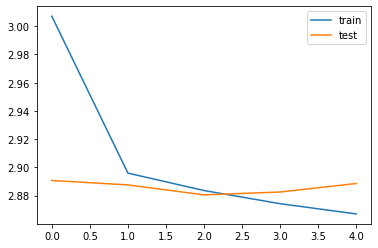

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 8-9. 인퍼런스 모델 구현하기
테스트 단계에선 정수 인덱스 행렬로 존재했던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비하기

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq은 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다. <br/><br/>
훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한 번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델을 하나만 준비함 <br/><br/>
정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해줘야 함. 이 때 인코더 모델과 디코더 모델을 분리하여 설계한다.

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs,
                      outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층 설계

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' ' + sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 8-10. 모델 테스트 하기
test 단계에선 정수 시퀀스를 **텍스트 시퀀스**로 변환하여 결과를 확인하는 것이 편하다. <br/>
주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어보자. 함수를 만들 땐
- Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고
- Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들자.

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i] + ' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : wondering happen homestyle popcorn favorite long time suddenly disappeared stores shopped long delicious everyone try orville redenbacher tender white butter almost good tastes like corn 
실제 요약 : no place like 
예측 요약 :  great


원문 : favorite bars sweet natural order bulk every time cranberries give bit tangy flavor makes right almonds taste fresh crunchy highly recommend 
실제 요약 : great bars 
예측 요약 :  great


원문 : love flavor hot chocolate rich smooth tried brands get results wanted definately ordering company 
실제 요약 : good and tasty 
예측 요약 :  great


원문 : cereal lovers check kellogg latest roasted nut honey comparable shape cheerios flavor like nothing else product stands much crunchy nut new flavor taste may blow mind flavor quickly many others category 
실제 요약 : solid addition to the cereal 
예측 요약 :  great


원문 : strong enough first cup morning need something strong wake maybe found stronger blend 
실제 요약 : green mountain coffee 
예측 요약 :  great


원문 : cats really like food wish co

예측 요약 :  great


원문 : kids love happy tot flavors including one price great subscribe save 
실제 요약 : kids love it 
예측 요약 :  great


원문 : got beans prescribed amount time even opened package knew going great amazing aroma beans evident actually opened packaging bought make vanilla extract say juicy beans highly recommend 
실제 요약 : awesome 
예측 요약 :  great


원문 : like one grab spoon skip toast complaint enough placed another order days later 
실제 요약 : so good just the toast 
예측 요약 :  great


원문 : cooking class years ago teacher chef brought crackers class share students since majority class spanish decent students hard time included raised mostly land critters diet eating kinda like kicked mouth fish even though fish strong kinda sweet admit though addicting get fishy taste 
실제 요약 : these bring back memories 
예측 요약 :  great


원문 : sampled cake offered month ago fell love extremely moist delicious sliced thin cup coffee ingredients perfectly blended one taste overpowering able taste individua

기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들도 존재한다. <br/>
심지어, 일부 요약은 원문에 없던 단어를 사용해 요약을 진행하기도 했다. <br/> <br/>

but, 좋지 않은 요약도 존재한다. 이러한 성능을 개선하기 위해서는 seq2seq와 어텐션의 조합을 좀 더 좋게 수정하거나, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 인코더-디코더 자체의 구조를 새로 변경하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재한다.

## 8-11. 추출적 요약 해보기
- 우린 지금까지 seq2seq를 통해 추상적 요약을 진행했다.
- 처음에 설명했듯이 본문에 존재하는 단어구, 문장을 뽑아 요약하는 추출적 요약도 존재한다.
    - 패키지 `Summa`에서 추출적 요약을 위한 모듈인 `summarize`를 제공한다.
    - 영화 매트릭스 시놉시스를 요약해보며 summarize 사용법을 익혀보자.

### 패키지 설치

In [ ]:
# $ pip list | grep summa

### 데이터 다운로드하기

In [50]:
import requests
from summa.summarizer import summarize

In [51]:
# 매트릭스 시놉시스 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

text에는 시놉시시스가 '문자열'로 저장되어 있다.

In [53]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기
> - text(str): 요약할 테스트
> - ratio(float, optional): 요약문에서 원본에서 선택되는 문장의 비율 (0-1)
> - words(int or None, optional): 출력에 포함할 단어 수 <br/>
> 만약 ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시함
> - split(bool, optional): True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않아도 내부적으로 문장 토큰화를 수행한다. 따라서 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. <br/>
원문의 0.005%만 요약문으로 출력하도록 문장의 개수 줄여보자.

In [55]:
print('Summary: ')
print(summarize(text, ratio=0.005))

Summary: 
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


만약 리스트로 출력 결과를 받고 싶다면? -> split=True

In [56]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


단어 수로 요약문의 크기 조절을 할 수도 있다.

In [57]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


***

# 📖 8-12. 프로젝트: 뉴스 기사 요약해보기
추상적 요약 / 추출적 요약을 모두 해보자.

## Step 1. 데이터 수집하기

In [152]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [153]:
data.sample(10)

,headlines,text
5092,Will show Modi govt how to treat minorities: P...,Pakistan PM Imran Khan has said that he'll sho...
60375,Twitter suspends Pak Defence account over fake...,Twitter on Saturday suspended Pakistan Defence...
8415,Ginni's dad told me 'shut up' when I sent marr...,Comedian Kapil Sharma has revealed his girlfri...
14259,Couple transporting body parts admits to killi...,A couple caught in Mexico transporting human b...
66044,"Andhra to give Ã¢ÂÂ¹30,000 to newlyweds from ...",The Andhra Pradesh Cabinet has approved a new ...
57102,Android Co-founder back at work after nearly a...,Android Co-founder Andy Rubin has reportedly r...
55509,App lets users add fart effects to videos usin...,Developer Something Ideal has developed an app...
49146,Self-publishing platform Pratilipi raises $4.3...,Bengaluru-based self-publishing platform Prati...
2747,"If ready for talks with Taliban, why not J&K s...",After Army Chief General Bipin Rawat suggested...
42278,Mandhana scores fastest T20I fifty for an Indi...,Smriti Mandhana broke her own record of scorin...


- `추상적 요약`인 경우: text를 본문, headlines를 이미 요약된 데이터로 삼아 모델 학습하기
- `추출적 요약`인 경우: 오직 text열만 사용

## Step 2. 데이터 전처리하기 (추상적 요약)
### 중복 샘플, null 값 제거
- text는 중복되어도 headlines는 동일할 수도 있다. (하지만 거의 희박하겠지?!)
- 일단 text에서 중복된 데이터를 제거하자.

In [154]:
print(len(data['text']))
print(len(data['text']) - data['text'].nunique())

98401
41


In [155]:
data.drop_duplicates(subset=['text'], inplace=True)
print('전체 text 샘플 수: ', len(data))

전체 text 샘플 수:  98360


In [156]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


null data는 제거할 필요 없다. 총 데이터 수는 중복 데이터 41개를 제거해 **98,360개**임을 확인!

### 텍스트 정규화와 불용어 제거
#### 정규화 사전 (dictionary)

In [157]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 불용어 (stopwords)
- NLTK에서 제공하는 불용어 리스트를 참조하자.

In [158]:
# NLTK에서 제공하는 불용어 리스트
print('불용어 개수: ', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수:  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

요약문의 결과가 자연스럽기 위해서는, 또 상대적으로 길이가 짧은 요약문에선 불용어들을 제거할 필요가 없다고 판단했다. 즉 불용어들이 headlines에 남아 있는 것이 좋다고 판단해 remove_stopwords로 둘을 분리할 것이다.

In [159]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text # <br />, <a href=...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens

text 불용어 제거

In [160]:
clean_text = []

# 전체 text 데이터에 대한 전처리: 10분 이상 소요
for s in data['text']:
    clean_text.append(preprocess_sentence(s))
    
# 전처리 후 출력
print('text 전처리 후 결과: ', clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

headlines 불용어 제거

In [161]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리: 5분 이상 시간 소요
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False)) # 불용어 제거 수행하지 않는다는 의미의 False
    
print("headlines 전처리 후 결과: ", clean_summary[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


애초에 길이가 짧은 데이터였다면, 정제 후 empty 샘플이 되었을 가능성이 있다.

In [162]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 null로 변환
data.replace('', np.nan, inplace=True)

In [163]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

정제 과정에서 null값은 생기지 않았다.

In [164]:
print(len(data))

98360


### 훈련 데이터, 테스트 데이터 나누기
#### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


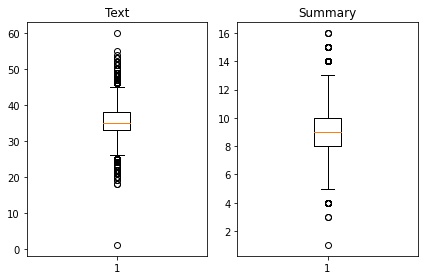

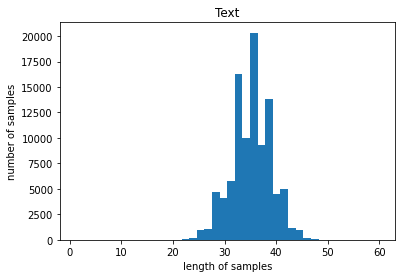

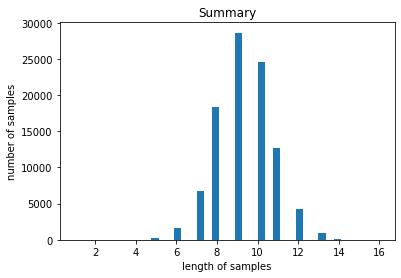

In [165]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1, 2, 2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

text문의 평균 길이는 35, headlines(요약문)의 평균 길이는 9임을 확인할 수 있다. <br/>
최대 길이 또한 각각 60, 16으로 요약문의 길이가 상대적으로 짧음을 알 수 있다.

In [166]:
text_max_len = 35
summary_max_len = 9

In [167]:
# 위의 길이가 적절한지 통계로 확인해보기
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s.split()) <= max_len):
            cnt = cnt + 1
            
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [168]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


최대 길이를 조금 조정해주자.

In [169]:
text_max_len = 38
summary_max_len = 12

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len, data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


padding으로 자르지 말고, 정해진 길이보다 길면 제외해보자.

In [170]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플 수: ', len(data))

전체 샘플 수:  79296


### 시작 토큰과 종료 토큰 추가하기
- seq2seq에선 디코더의 입력과 출력 sostoekn, eostoken을 추가할 필요가 있다.
- **디코더의 입력**이며 `sostoken`이 맨 앞에 있는 문장은 `decoder_input`, **디코더의 출력**에 해당하며 `eostoken`이 맨 뒤에 붙은 문장은 `decoder_target`이라 명명하자.

In [171]:
# 요약 데이터에 시작 토큰과 종료 토큰을 추가함
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [172]:
encoder_input = np.array(data['text']) # 인코더의 입력 (text)
decoder_input = np.array(data['decoder_input']) # 디코더의 입력 (sostoken + Summary)
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블 (Summary + eostoken)

In [173]:
# `encoder_input`과 크기, 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 이 정수 시퀀스(indices)를 통해 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플이 될 것이다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoer_target = decoder_target[indices]

In [174]:
# 8:2로 train/test 데이터 분리
n_of_val = int(len(encoder_input) * 0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 63437
훈련 레이블의 개수 : 63437
테스트 데이터의 개수 : 15859
테스트 레이블의 개수 : 15859


### 정수 인코딩
#### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [175]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

단어 집합이 생김과 동시에 각 단어에 고유한 정수가 부여되었고, 이는 `src_tokenizer.word_index`에 저장되어 있다. <br/>
빈도수가 낮은 단어들은 train 데이터에서 제외하자.
- `src_tokenizer.word_counts().items()`: 단어와 각 단어의 등장 빈도수가 저장됨

In [176]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수 카운트
total_freq = 0 # 훈련 빈도수의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 낮은 단어의 등장 빈도수 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in src_tokenizer.word_counts.items():
    total_freq += value # 총 빈도수
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt += 1
        rare_freq = rare_freq + value # rare 빈도수
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61050
등장 빈도가 7번 이하인 희귀 단어의 수: 42949
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18101
단어 집합에서 희귀 단어의 비율: 70.35053235053235
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.379852177312755


- 등장 빈도가 8 미만인 단어들은 74%나 되지만 전체 빈도수로 따지면 4.4%밖에 등장하지 않는다.
- 이 단어들은 정수 인코딩 과정에서 제외하고, 훈련 데이터에서 제거하자.
- 단어 집합의 크기를 18,000으로 제한하자.

In [177]:
src_vocab = 18000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3685, 380, 3089, 12338, 1221, 3929, 65, 170, 380, 194, 484, 81, 1, 3686, 1556, 986, 20, 1440, 101, 1068, 16984, 106, 14487, 986, 20, 863, 31, 21], [5, 3018, 74, 1247, 5129, 5, 463, 1167, 2876, 13868, 31, 1193, 3288, 903, 9887, 2548, 31, 1668, 2240, 215, 958, 1182, 3960, 915, 3899, 4393, 916, 1450, 9175], [94, 6037, 3687, 30, 6105, 1115, 628, 235, 96, 329, 7370, 1038, 1716, 181, 431, 332, 628, 3687, 3688, 1197, 1556, 1198, 602, 15183, 1144, 5885, 385, 181, 235, 87, 4700, 6200, 21]]


Summary 데이터에 대해서도 동일한 작업을 수행하자.

In [178]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [183]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27308
등장 빈도가 5번 이하인 희귀 단어의 수: 18036
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9272
단어 집합에서 희귀 단어의 비율: 66.0465797568478
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.287565439595815


In [184]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ', decoder_input_train[:5])
print('target')
print('decoder ', decoder_target_train[:5])

input
input  [[1, 7297, 950, 6, 413, 4, 602, 157], [1, 15, 1967, 85, 1677, 6], [1, 1678, 5, 59, 6, 248, 316, 5, 3530, 2150], [1, 15, 162, 89, 2692, 1319, 3, 1509, 83, 565], [1, 110, 2895, 3351, 1027, 148, 479, 4306, 732]]
target
decoder  [[46, 1271, 367, 475, 551, 699, 11, 170, 786, 4406, 2], [8375, 182, 8376, 2194, 485, 1104, 1735, 748, 328, 2], [8090, 674, 151, 325, 611, 459, 5, 1939, 1731, 2], [11, 65, 94, 51, 5, 209, 2620, 327, 1522, 4, 46, 1271, 2], [23, 2616, 2500, 3568, 3, 750, 201, 54, 159, 45, 2166, 2]]


우린 전체 데이터에서 빈도수가 낮은 단어를 삭제 했다. 이 과정으로 특히 평균 길이가 짧았던 Summary에서 empty 샘플이 되었을 가능성이 있기 때문에 길이가 0이 된 샘플의 인덱스를 받아보자. <br/> 주의해야 할 점은 `decoder_input`엔 sostoken이, `decoder_target`엔 eostoken이 포함되었으므로 길이가 0인 요약문의 실제 길이가 1로 나올 것이다.

In [185]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 63437
훈련 레이블의 개수 : 63437
테스트 데이터의 개수 : 15859
테스트 레이블의 개수 : 15859


길이가 0이 된 summary 데이터가 없었음을 알 수 있다.

#### 패딩하기

In [186]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

### 모델 설계하기
- 함수형 API를 이용하자.

In [187]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [188]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) # 체크

In [189]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 38, 128)      2304000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 38, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## Step 3. 어텐션 매커니즘 사용하기 (추상적 요약)
- 일반적인 seq2seq보다 어텐션 메커니즘을 이용해 더 나은 성능을 내보자.

In [191]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층 (어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 38, 128)      2304000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 38, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [192]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
248/248 [==============================] - 143s 545ms/step - loss: 5.9155 - val_loss: 5.6220
Epoch 2/50
248/248 [==============================] - 134s 541ms/step - loss: 5.7781 - val_loss: 5.5904
Epoch 3/50
248/248 [==============================] - 133s 538ms/step - loss: 5.7540 - val_loss: 5.6173
Epoch 4/50
248/248 [==============================] - 133s 535ms/step - loss: 5.7356 - val_loss: 5.6575
Epoch 00004: early stopping


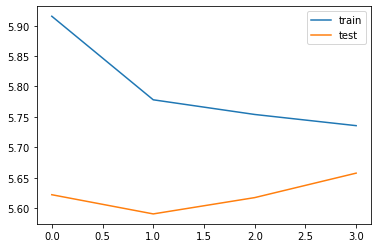

In [193]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [194]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [195]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs,
                      outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [196]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [197]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' ' + sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
test 단계에선 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다.
- text의 정수 시퀀스에선 패딩을 위해 사용된 숫자 0을 제외하고
- summary의 정수 시퀀스에선 숫자 0, sostoken, eostoken을 출력에서 제외하자.

In [198]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i] + ' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [199]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former air hostess khanna accusing singer abhijeet bhattacharya sexually harassing hotel claimed called almost kissed ear allegedly happened refused get intimate hotel knew well abhijeet banned visiting hotel month added 
실제 요약 : singer abhijeet called me on my ear ex air hostess 
예측 요약 :  us to to to to to in


원문 : indian cricket captain virat kohli tweeted best wishes south africa ab de villiers announced retirement international cricket recently part kohli tweet read wish best everything brother changed way batting seen time played international cricket 
실제 요약 : you have changed the way batting was seen kohli to abd 
예측 요약 :  us to to to to to in


원문 : filmmaker jai claimed sunny leone emraan hashmi starrer song piya film baadshaho copied prakash said lifted song named pe film saturday night songs composed music director ankit tiwari 
실제 요약 : filmmaker claims baadshaho song piya more is copied 
예측 요약 :  man to to to to to in


원문 : technology major apple tuesday hiked dividen

예측 요약 :  us to to to to to in


원문 : record sixes hit ipl match set royal challengers bangalore chennai super kings match wednesday many sixes hit breaking previous record sixes smashed delhi daredevils gujarat lions match last year notably record sixes match 
실제 요약 : csk rcb match witnesses sixes the most in an ipl match 
예측 요약 :  us to to to to in in


원문 : three chinese women detained airport south korea faces match passport pictures underwent plastic surgery officials refused believe women tried prove identity despite showing tickets various documents according reports reportedly several chinese women go south korea get plastic surgeries 
실제 요약 : women fail to prove identity after plastic surgery detained 
예측 요약 :  us to to to to in in


원문 : commerce giant amazon would beat apple google become first company trillion market cap new york university professor scott said stating winners consumers amazon shareholders added amazon poised capture percent purchases consumers 
실제 요약 : amaz

예측 요약 :  man to to to to to in




'EarlyStopping'에 대해 배울 수 있었음. 항상 궁금했음.